In [2]:
!pip freeze > requirements.txt

In [ ]:
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
import pandas as pd

import numpy as np
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

#---------- PARAMS -----------
KT = 0.199  # motors torque constant
POLE_PAIR = 21
GR = 8

# ---------------- setup ----------------
typestore = get_typestore(Stores.ROS2_JAZZY)
transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

required_topics = {
    '/fixposition/fpa/odomenu'
    # '/motor_feedback',
    # '/steering_pub'
}

bagpath = Path("./regen_brake_bags")
    
for bagpath in bag_dir.glob("*.bag"):
    
    rows = []

    # ---------------- read bag ----------------
    with AnyReader([bagpath], default_typestore=typestore) as reader:
        connections = [c for c in reader.connections if c.topic in required_topics]

        for c, t, raw in reader.messages(connections=connections):

            msg = reader.deserialize(raw, c.msgtype)
            time = t * 1e-9  # ns → seconds
            time = datetime.fromtimestamp(time)

            row = {"time": time}

            # -------- odometry --------
            
            p = msg.pose.pose.position
            q = msg.pose.pose.orientation
            v = msg.velocity.twist.linear
            w = msg.velocity.twist.angular
            a = msg.acceleration 

            lon, lat, alt = transformer.transform(p.x, p.y, p.z)
            yaw, pitch, roll = R.from_quat(
                [q.x, q.y, q.z, q.w]
            ).as_euler("zyx", degrees=True)
            

            row.update({
                "lat": lat,
                "lon": lon,
                "alt": alt,
                "yaw": yaw,
                "pitch": pitch,
                "roll": roll,
                "vx":v.x,
                "vy":v.y,
                "vz":v.z,
                "ax": a.x, 
                "ay": a.y, 
                "az": a.z,
                "yaw_rate": w.x, 
                "pitch_rate": w.y,
                "roll_rate": w.z
            })
            
            # -------- motor feedback --------
            # if c.topic == '/motor_feedback':
            #     row.update({
            #         "pos": msg.data[0],
            #         "rpm": msg.data[1]*(POLE_PAIR*GR),
            #         "torque": msg.data[2]*KT,
            #         "temp": msg.data[3],
            #         "err": msg.data[4]
            #     })

            # # -------- steering --------
            # if c.topic == '/steering_pub':
            #     row.update({
            #         "steering_vel": msg.linear.x
            #     })


            rows.append(row)

    # ---------------- dataframe ----------------

    df = pd.DataFrame(rows)  #.sort_values("time")

    df.yaw = df.yaw*np.pi/180
    df['uncorrect_yaw'] = df.yaw
    df.yaw = np.unwrap(df.yaw)
    
    csv_path = f"./brake_csv/{bagpath.name.replace(".bag", "_data.csv")}"
    df.to_csv(csv_path, index=True)


AssertionError: 

<Axes: >

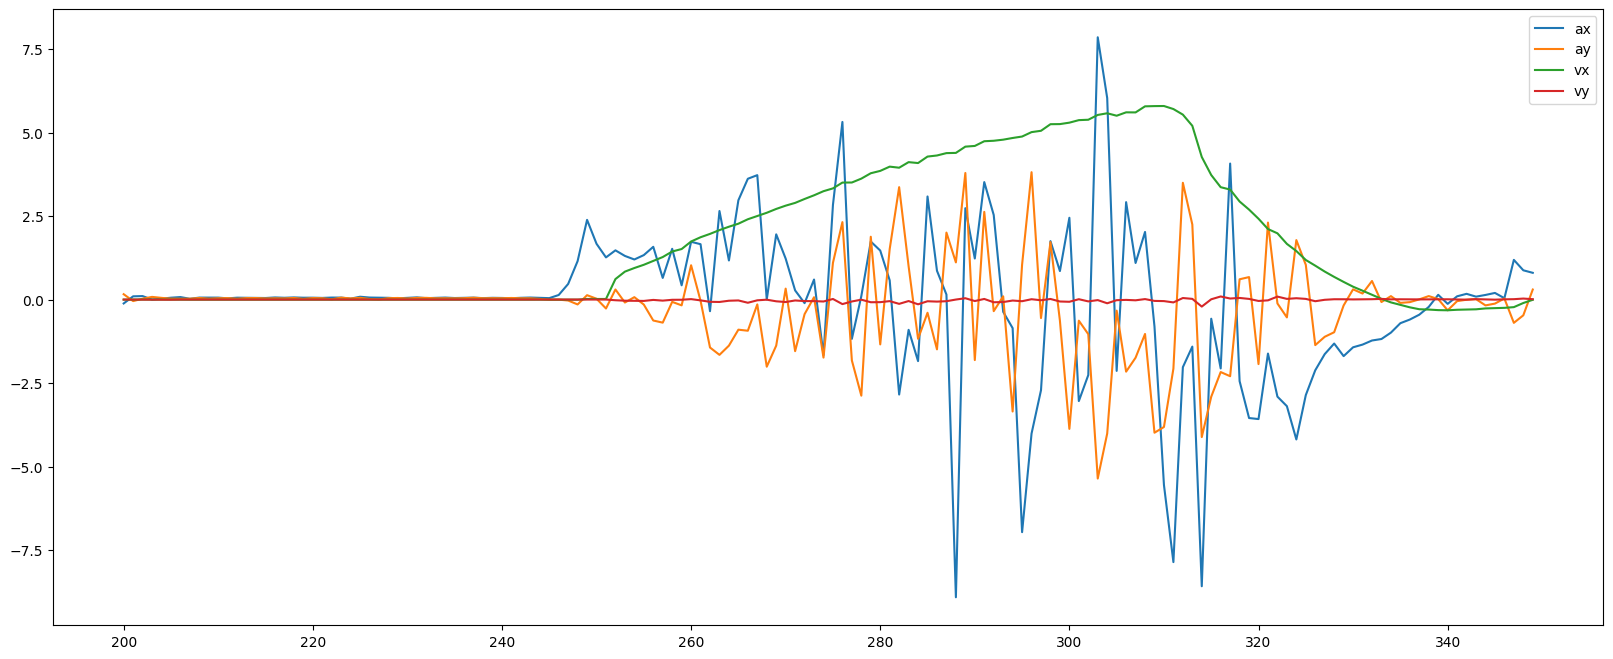

In [17]:
dp = ['lat', 'lon', 'alt' , 'az']
show = ['ax' , 'ay' , 'vx' , 'vy']
# data = df.drop(columns=dp)
data = df[show]

data.iloc[200:350].plot(figsize=(20,8))

In [10]:
df.to_csv("day_3_regen_23m_trial_v42_data.csv", index=True)